**NHẬN DIỆN BÚT CHÌ VÀ BÚT BI**

In [1]:
# Cài đặt các thư viện
!pip install roboflow pyyaml tqdm ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 36.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 40.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s e

In [2]:


from roboflow import Roboflow
import os

# Sử dụng API key trực tiếp (chỉ dùng cho testing)
rf = Roboflow(api_key="P5fLcTL1Iebtyx4N381u")
workspace = rf.workspace("objdetecpen")

# Tải datasets
project_a = workspace.project("all-objects-1-z1qkf")
dataset_a = project_a.version(1).download("yolov8")

project_b = workspace.project("pen-x2n7a-x0key")
dataset_b = project_b.version(1).download("yolov8")

print("Download completed!")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to All-objects-1-1 in yolov8:: 100%|██████████| 6480/6480 [00:02<00:00, 2215.44it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
loading Roboflow project...



Extracting Dataset Version Zip to pen-1 in yolov8:: 100%|██████████| 2012/2012 [00:00<00:00, 6347.44it/s]

Download completed!


In [3]:
import os
import shutil

# Dataset paths trên Kaggle
dataset_a = "/kaggle/working/All-objects-1-1"
dataset_b = "/kaggle/working/pen-1" 
merged = "/kaggle/working/merged_with_eraser"

# Tạo thư mục
for split in ["train", "valid", "test"]:
    os.makedirs(os.path.join(merged, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(merged, split, "labels"), exist_ok=True)

def copy_and_remap(src, dst, mapping):
    for split in ["train", "valid", "test"]:
        img_dir = os.path.join(src, split, "images")
        lbl_dir = os.path.join(src, split, "labels")
        if not os.path.exists(img_dir): continue

        # Copy ảnh
        for file in os.listdir(img_dir):
            shutil.copy(os.path.join(img_dir, file), os.path.join(dst, split, "images", file))

        # Remap nhãn
        for file in os.listdir(lbl_dir):
            lbl_src = os.path.join(lbl_dir, file)
            lbl_dst = os.path.join(dst, split, "labels", file)
            
            new_lines = []
            with open(lbl_src, "r") as f:
                for line in f:
                    cls, *coords = line.strip().split()
                    if int(cls) in mapping:
                        new_lines.append(f"{mapping[int(cls)]} {' '.join(coords)}")
            
            if new_lines:
                with open(lbl_dst, "w") as f:
                    f.write("\n".join(new_lines))

# Merge datasets
copy_and_remap(dataset_a, merged, {0:0, 1:1, 2:2})  # Dataset A
copy_and_remap(dataset_b, merged, {0:1})             # Dataset B

# Tạo file data.yaml
with open(os.path.join(merged, "data.yaml"), "w") as f:
    f.write(f"""path: {merged}
train: train/images
val: valid/images
test: test/images

names:
  0: eraser
  1: pen
  2: pencil
""")

print("✅ Dataset merged tại:", merged)

✅ Dataset merged tại: /kaggle/working/merged_with_eraser


In [4]:
import glob

for split in ["train", "valid", "test"]:
    imgs = glob.glob(f"{merged}/{split}/images/*.jpg")
    lbls = glob.glob(f"{merged}/{split}/labels/*.txt")
    print(f"{split}: {len(imgs)} images, {len(lbls)} labels")

# Đếm instance từng class
counts = {"eraser": 0, "pen": 0, "pencil": 0}
for split in ["train", "valid", "test"]:
    for lbl_file in glob.glob(f"{merged}/{split}/labels/*.txt"):
        with open(lbl_file, "r") as f:
            for line in f:
                cls = int(line.split()[0])
                if cls == 0:
                    counts["eraser"] += 1
                elif cls == 1:
                    counts["pen"] += 1
                elif cls == 2:
                    counts["pencil"] += 1

print("\nSố lượng instance sau merge:")
print(counts)


train: 3211 images, 3209 labels
valid: 689 images, 689 labels
test: 334 images, 334 labels

Số lượng instance sau merge:
{'eraser': 916, 'pen': 2972, 'pencil': 2800}


In [5]:
# model = YOLO("yolov8m.pt")   # thử model to hơn

# model.train(
#     data="/content/merged_with_eraser/data.yaml",
#     epochs=100,
#     imgsz=640,
#     batch=32,      # hoặc 64 nếu GPU chịu được
#     workers=2,     # Colab T4 thường có 2 CPU core
#     device=0,      
#     amp=True,      # mixed precision (fp16)
#     patience=20,
#     name="pen_pencil_eraser_opt"
# )


In [6]:
from ultralytics import YOLO
import shutil
import os

# Train model
model = YOLO("yolov8m.pt")
model.train(
    data="/kaggle/working/merged_with_eraser/data.yaml",
    epochs=100,
    imgsz=640,
    batch=32,
    workers=2,
    device=0,
    amp=True,
    patience=20,
    name="pen_pencil_eraser_opt"
)

# SAU KHI TRAINING - sửa đường dẫn cho đúng
training_dir = "/kaggle/working/runs/detect/pen_pencil_eraser_opt"

if os.path.exists(training_dir):
    # Copy best model
    shutil.copy(f"{training_dir}/weights/best.pt", "/kaggle/working/best_model.pt")
    
    # Nén toàn bộ kết quả
    shutil.make_archive("/kaggle/working/training_results", 'zip', training_dir)
    
    print("✅ Backup completed!")
    print("📁 Download: training_results.zip")
    print("🏆 Best model: best_model.pt")
else:
    print("❌ Training directory not found! Check path:")
    print("Expected:", training_dir)
    print("Available in /kaggle/working/runs/detect/:")
    !ls -la "/kaggle/working/runs/detect/"

Ultralytics 8.3.204 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/merged_with_eraser/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pen_pencil_eraser_opt, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patienc

invalid value encountered in less
invalid value encountered in less


                   all        689       1084      0.939      0.901      0.935      0.857
                eraser        159        170      0.988      0.987      0.994      0.979
                   pen        369        525      0.889       0.78      0.851      0.715
                pencil        172        389      0.939      0.936      0.961      0.877
Speed: 0.1ms preprocess, 8.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/runs/detect/pen_pencil_eraser_opt
✅ Backup completed!
📁 Download: training_results.zip
🏆 Best model: best_model.pt


In [10]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/runs/detect/pen_pencil_eraser_opt/weights/best.pt")  # hoặc last.pt

# Evaluate trên test set
metrics = model.val(data="/kaggle/working/merged_with_eraser/data.yaml", split="test")

print(metrics)


Ultralytics 8.3.204 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 33.6±30.2 MB/s, size: 300.4 KB)
val: Scanning /kaggle/working/merged_with_eraser/test/labels... 334 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 334/334 431.3it/s 0.8s0.1s
val: New cache created: /kaggle/working/merged_with_eraser/test/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 382, len(boxes) = 558. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 21/21 3.5it/s 5.9s0.2s


invalid value encountered in less
invalid value encountered in less


                   all        334        558      0.917      0.851      0.906      0.817
                eraser         75         85      0.996      0.988      0.992      0.982
                   pen        181        235      0.796      0.791      0.853      0.722
                pencil         85        238       0.96      0.773      0.874      0.748
Speed: 1.9ms preprocess, 10.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b92923f4410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,  


image 1/1 /kaggle/working/merged_with_eraser/test/images/642ec8d3b70d42dcfae8e0c0131750cf_jpg.rf.537ca4b6e3988b7c357196df1bc06a29.jpg: 640x640 5 erasers, 16.3ms
Speed: 2.9ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


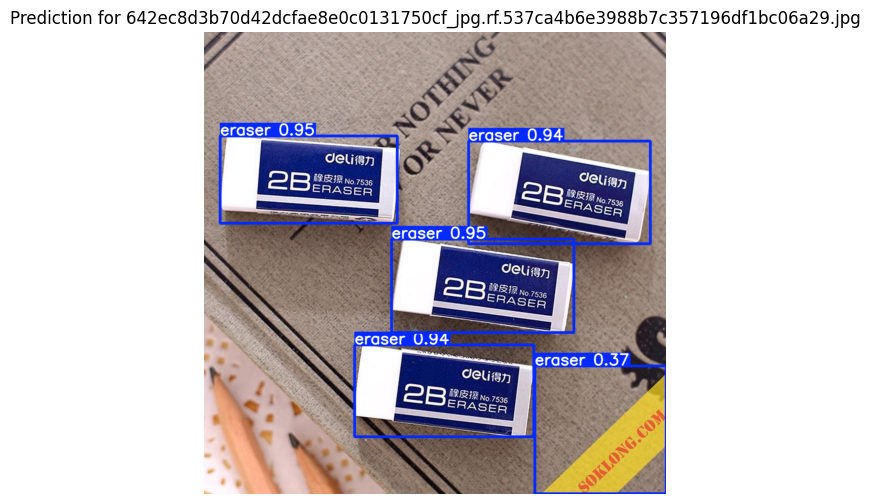


image 1/1 /kaggle/working/merged_with_eraser/test/images/z5246265720532_d01a1d91bf2581936b24ecb84ab168d6_jpg.rf.32109c4c1ed4d8f65ba92b341cbc0f79.jpg: 640x480 1 pencil, 14.7ms
Speed: 2.6ms preprocess, 14.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


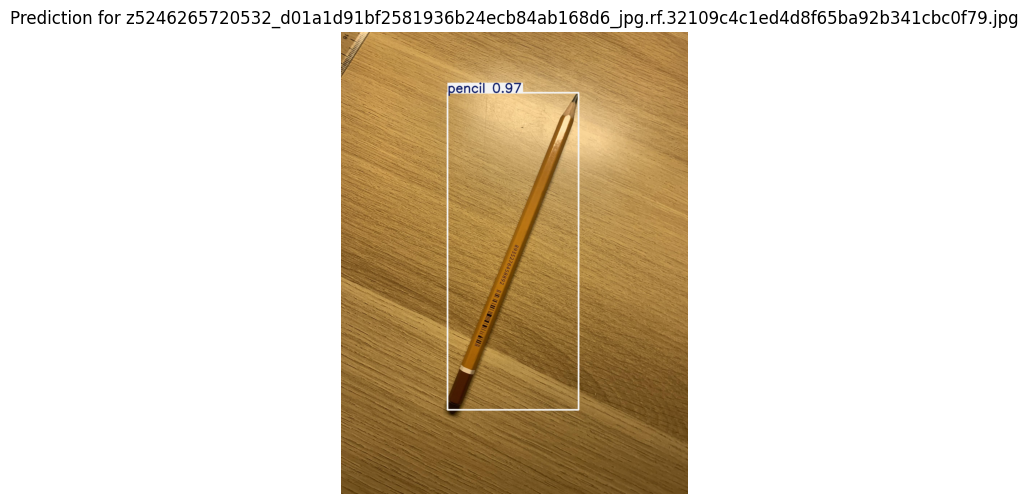


image 1/1 /kaggle/working/merged_with_eraser/test/images/0aef70543892e48a_jpg.rf.f4fa12b446adbad2e81d04e53688b77c.jpg: 480x640 1 pen, 15.2ms
Speed: 2.7ms preprocess, 15.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


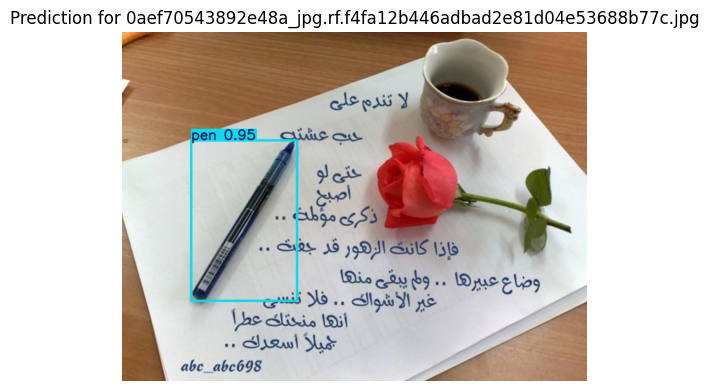


image 1/1 /kaggle/working/merged_with_eraser/test/images/3965b8ed60a31c4a_jpg.rf.b0cdcf19fdbcdf431c8dfc43c3b7ed85.jpg: 448x640 4 pens, 13.6ms
Speed: 2.2ms preprocess, 13.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


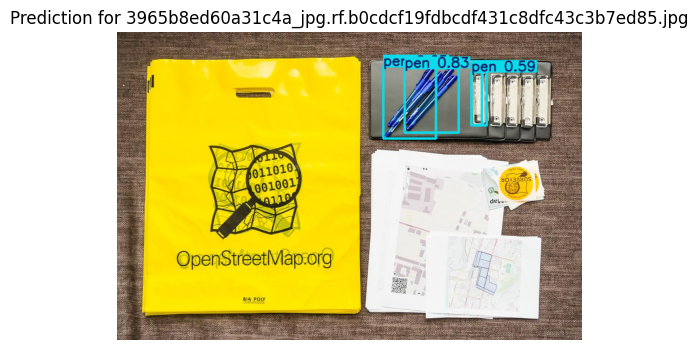


image 1/1 /kaggle/working/merged_with_eraser/test/images/3ce537bd7745286f_jpg.rf.b055860fc1a406aa4afac34e2e543299.jpg: 640x640 2 pens, 17.1ms
Speed: 4.2ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


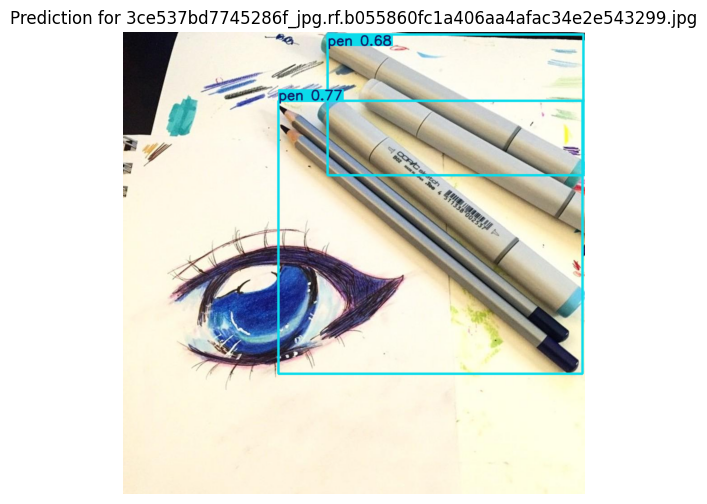

In [12]:
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Load model đã train
model = YOLO("/kaggle/working/runs/detect/pen_pencil_eraser_opt/weights/best.pt")  # thay bằng best.pt hoặc last.pt

# Lấy danh sách ảnh test
test_images = os.listdir("/kaggle/working/merged_with_eraser/test/images")

# Chọn ngẫu nhiên 10 ảnh
sample_images = random.sample(test_images, 5)

# Hiển thị từng ảnh với prediction
for img_name in sample_images:
    img_path = f"/kaggle/working/merged_with_eraser/test/images/{img_name}"
    
    # Chạy predict
    results = model.predict(source=img_path, imgsz=640, conf=0.25, save=False, line_width=2)
    
    # Vẽ prediction lên ảnh
    res_plotted = results[0].plot()  # numpy array BGR
    
    # Hiển thị bằng matplotlib
    plt.figure(figsize=(6,6))
    plt.imshow(res_plotted[..., ::-1])  # đổi BGR -> RGB
    plt.axis("off")
    plt.title(f"Prediction for {img_name}")
    plt.show()



image 1/1 /kaggle/input/testpen/testImage2.jpg: 448x640 1 pen, 1 pencil, 13.5ms
Speed: 2.8ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


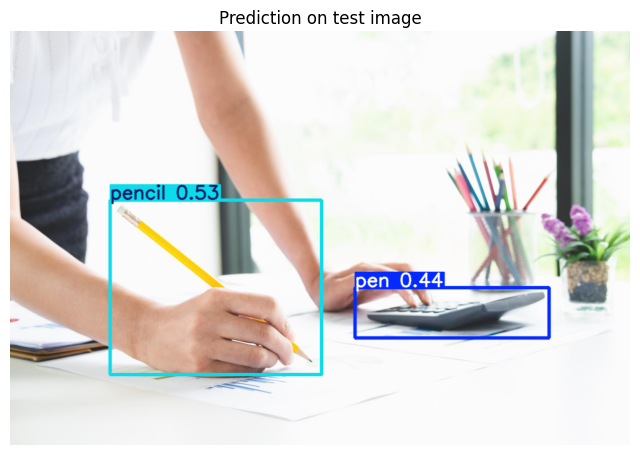

In [17]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load model
model = YOLO("/kaggle/working/runs/detect/train2/weights/best.pt")  # thay đường dẫn nếu khác

# Đường dẫn ảnh
img_path = "/kaggle/input/testpen/testImage2.jpg"

# Dự đoán
results = model.predict(source=img_path, imgsz=640, conf=0.25)

# Vẽ kết quả
res_plotted = results[0].plot()

plt.figure(figsize=(8,8))
plt.imshow(res_plotted[..., ::-1])  # đổi BGR -> RGB
plt.axis("off")
plt.title("Prediction on test image")
plt.show()


In [18]:
# Đường dẫn video
video_path = "/kaggle/input/testpen/videoTest.mp4"

# Dự đoán trên video (YOLO sẽ lưu kết quả vào runs/detect/predict)
results = model.predict(
    source=video_path, 
    imgsz=640, 
    conf=0.25, 
    save=True  # lưu video output
)

print("✅ Video đã được xử lý và lưu tại:", results[0].save_dir)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/447) /kaggle/input/testpen/videoTest.mp4: 640x384 2 pens, 14.3ms
video 1/1 (frame 2/447) /kaggle/input/testpen/videoTest.mp4: 640x384 2 pens, 14.0ms
video 1/1 (frame 3/447) /kaggle/input/testpen/videoTest.mp4: 640x384 2 pens, 14.0ms
video 1/1 (frame 4/447) /kaggle/input/testpen/videoTest.mp4: 640x384 2 pens, 13.7ms
video 1/1 (frame 5/447) /kaggle/input/testpen/videoTest.mp4: 640x384 2 pens, 14.0ms
video 1/1 (frame 6/447) /kaggle/inpu

**Train tiếp data bổ sung**

In [4]:
!pip install ultralytics roboflow 


  Using cached ultralytics-8.3.204-py3-none-any.whl.metadata (37 kB)
  Using cached roboflow-1.2.10-py3-none-any.whl.metadata (9.7 kB)
  Using cached ultralytics_thop-2.0.17-py3-none-any.whl.metadata (14 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached pi_heif-1.1.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.5 kB)
  Using cached pillow_avif_plugin-1.5.2-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_

In [7]:
from roboflow import Roboflow

rf = Roboflow(api_key="P5fLcTL1Iebtyx4N381u")
project = rf.workspace("objdetecpen").project("pen-and-pencil-pvytj")
dataset = project.version(1).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


In [9]:
!cp /kaggle/input/lasttrain1t10/last.pt last.pt


In [13]:
from ultralytics import YOLO

# Load best.pt
model = YOLO("/kaggle/working/last.pt")

# Train tiếp
model.train(
    data="/kaggle/working/pen-and-pencil-1/data.yaml", 
            # /kaggle/working/pen-and-pencil-1/data.yaml
    epochs=50, 
    imgsz=640,
    batch=32,
    workers=2,
    device=0,
    patience=15
    # lr0=0.001  # giảm learning rate để fine-tune mượt hơn
)

   # data="/kaggle/working/merged_with_eraser/data.yaml",
   #  epochs=100,
   #  imgsz=640,
   #  batch=32,
   #  workers=2,
   #  device=0,
   #  amp=True,
   #  patience=20,
   #  name="pen_pencil_eraser_opt"

Ultralytics 8.3.204 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pen-and-pencil-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15,

invalid value encountered in less
invalid value encountered in less


                   all          8         23      0.793      0.785      0.831      0.704
                   pen          4         13      0.704      0.769      0.806      0.708
                pencil          6         10      0.881        0.8      0.856        0.7
Speed: 0.2ms preprocess, 9.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7919d5728810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [14]:
import shutil

# Nén thư mục train2 thành file zip
shutil.make_archive("/kaggle/working/train2_results", 'zip', "/kaggle/working/runs/detect/train2")

print("✅ Đã nén thành: train2_results.zip")
print("📥 Giờ hãy download file zip từ panel bên phải!")

✅ Đã nén thành: train2_results.zip
📥 Giờ hãy download file zip từ panel bên phải!
